In [13]:
!pip install scikit-fuzzy
!pip install pyswarm
!pip install scipy

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import random
from pyswarm import pso
from scipy.optimize import differential_evolution

# Part 1

In [15]:
# Define universe ranges for inputs and outputs
temperature_range = np.arange(0, 41, 1)  # Temperature from 0°C to 40°C
light_range = np.arange(0, 101, 1)  # Light levels in lumens from 0 to 100
humidity_range = np.arange(0, 101, 1)  # Humidity from 0% to 100%

In [16]:
# Define fuzzy variables for inputs
temperature = ctrl.Antecedent(temperature_range, 'temperature')
light = ctrl.Antecedent(light_range, 'light')
humidity = ctrl.Antecedent(humidity_range, 'humidity')

In [17]:
# Define fuzzy variables for outputs
heater = ctrl.Consequent(np.arange(0, 101, 1), 'heater')
light_output = ctrl.Consequent(np.arange(0, 101, 1), 'light_output')
fan = ctrl.Consequent(np.arange(0, 101, 1), 'fan')

Defining Fuzzy Sets Dynamically

In [18]:
# Apply chromosome to define fuzzy sets dynamically
def apply_chromosome_to_flc(chromosome):
    # Apply to temperature fuzzy sets
    temperature['cold'] = fuzz.gaussmf(temperature_range, chromosome[0], chromosome[1])
    temperature['warm'] = fuzz.gaussmf(temperature_range, chromosome[2], chromosome[3])
    temperature['hot'] = fuzz.gaussmf(temperature_range, chromosome[4], chromosome[5])

    # Apply to light fuzzy sets
    if not (chromosome[6] <= chromosome[7] <= chromosome[8] <= chromosome[9]):
        raise ValueError("Invalid chromosome values for 'light[dim]'.")
    light['dim'] = fuzz.trapmf(light_range, [chromosome[6], chromosome[7], chromosome[8], chromosome[9]])
    light['moderate'] = fuzz.trapmf(light_range, [chromosome[10], chromosome[11], chromosome[12], chromosome[13]])
    light['bright'] = fuzz.trapmf(light_range, [chromosome[14], chromosome[15], chromosome[16], chromosome[17]])

    # Apply to humidity fuzzy sets
    humidity['low'] = fuzz.trapmf(humidity_range, [chromosome[18], chromosome[19], chromosome[20], chromosome[21]])
    humidity['medium'] = fuzz.trapmf(humidity_range, [chromosome[22], chromosome[23], chromosome[24], chromosome[25]])
    humidity['high'] = fuzz.trapmf(humidity_range, [chromosome[26], chromosome[27], chromosome[28], chromosome[29]])

    # Apply to heater output fuzzy sets
    heater['low'] = fuzz.trimf(heater.universe, [chromosome[30], chromosome[31], chromosome[32]])
    heater['medium'] = fuzz.trimf(heater.universe, [chromosome[33], chromosome[34], chromosome[35]])
    heater['high'] = fuzz.trimf(heater.universe, [chromosome[36], chromosome[37], chromosome[38]])

    # Apply to light output fuzzy sets
    light_output['dim'] = fuzz.trimf(light_output.universe, [chromosome[39], chromosome[40], chromosome[41]])
    light_output['moderate'] = fuzz.trimf(light_output.universe, [chromosome[42], chromosome[43], chromosome[44]])
    light_output['bright'] = fuzz.trimf(light_output.universe, [chromosome[45], chromosome[46], chromosome[47]])

    # Apply to fan output fuzzy sets
    fan['low'] = fuzz.trimf(fan.universe, [chromosome[48], chromosome[49], chromosome[50]])
    fan['medium'] = fuzz.trimf(fan.universe, [chromosome[49], (chromosome[50] + chromosome[51]) / 2, chromosome[51]])  # Adding medium membership function
    fan['high'] = fuzz.trimf(fan.universe, [chromosome[51], chromosome[52], chromosome[53]])

    return temperature, light, humidity, heater, light_output, fan


In [19]:
# Example chromosome to apply
chromosome = [
    10, 5, 20, 5, 30, 5,        # temperature (cold, warm, hot)
    0, 0, 25, 50, 25, 50, 50, 75, 50, 100, 100, 100,  # light (dim, moderate, bright)
    0, 0, 25, 50, 25, 50, 50, 75, 50, 100, 100, 100,  # humidity (low, medium, high)
    0, 0, 50, 25, 50, 75, 50, 100, 100,  # heater (low, medium, high)
    0, 0, 50, 25, 50, 75, 50, 100, 100,  # light output (dim, moderate, bright)
    0, 0, 50, 50, 100, 100  # fan (low, high)
]


# Apply the chromosome to define fuzzy sets
temperature, light, humidity, heater, light_output, fan = apply_chromosome_to_flc(chromosome)


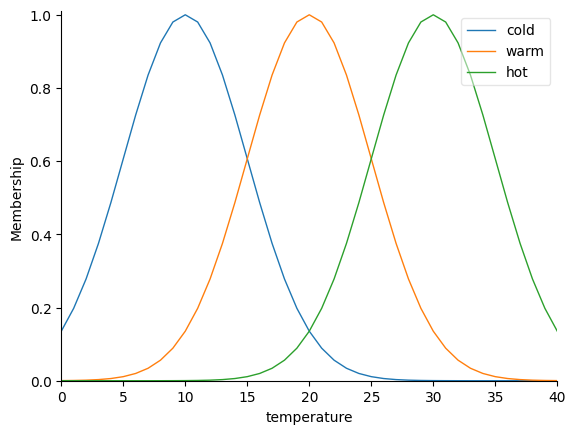

In [20]:
temperature.view()

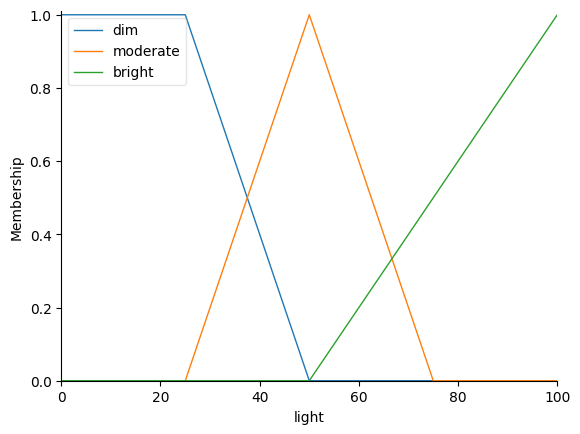

In [21]:
light.view()

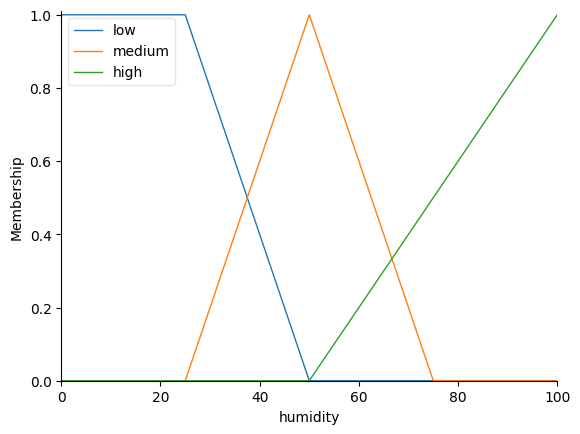

In [22]:
humidity.view()

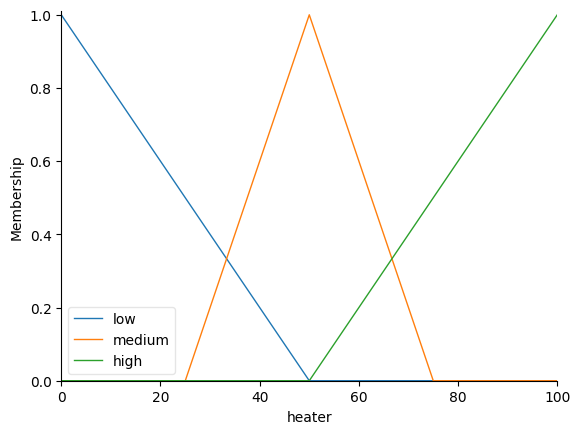

In [23]:
# Visualize heater output membership function
heater.view()

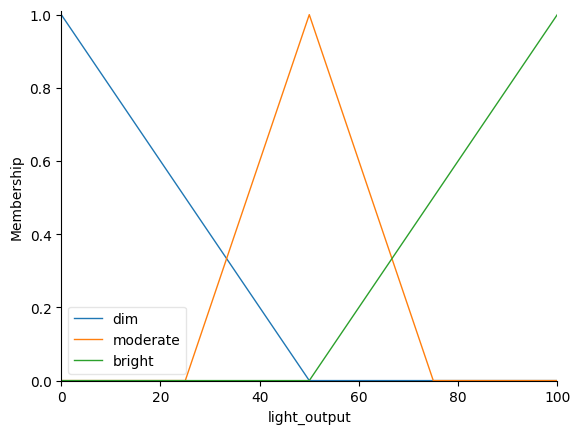

In [24]:
# Visualize heater output membership function
light_output.view()

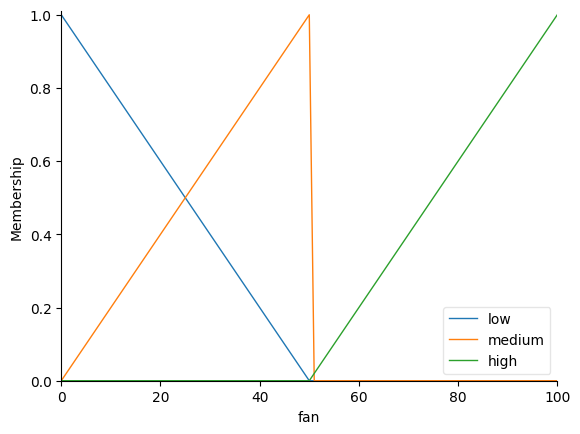

In [25]:
# Visualize heater output membership function
fan.view()

In [26]:
# Define fuzzy rules
rule1 = ctrl.Rule(temperature['cold'] & light['dim'], [heater['high'], light_output['bright']])
rule2 = ctrl.Rule(temperature['hot'] & humidity['high'], fan['high'])
rule3 = ctrl.Rule(temperature['cold'] & humidity['low'], heater['high'])
rule4 = ctrl.Rule(temperature['warm'] & light['moderate'], [heater['medium'], light_output['moderate']])
rule5 = ctrl.Rule(temperature['hot'] & light['bright'], light_output['dim'])
rule6 = ctrl.Rule(temperature['hot'] & humidity['low'], fan['high'])
rule7 = ctrl.Rule(temperature['warm'] & humidity['high'], fan['low'])
rule8 = ctrl.Rule(light['dim'] & humidity['medium'], light_output['bright'])
rule9 = ctrl.Rule(temperature['cold'] & humidity['high'], fan['low'])
rule10 = ctrl.Rule(temperature['hot'] & humidity['medium'], fan['medium'])

In [27]:
# Add these new rules to the control system
system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10])
simulation = ctrl.ControlSystemSimulation(system)

In [28]:
# Define different test scenarios for input values
test_scenarios = [
    {'temperature': 5, 'light': 20, 'humidity': 30},   # Cold, Dim light, Low humidity
    {'temperature': 22, 'light': 50, 'humidity': 60},  # Warm, Moderate light, Medium humidity
    {'temperature': 35, 'light': 80, 'humidity': 90},  # Hot, Bright light, High humidity
    {'temperature': 8, 'light': 90, 'humidity': 20},   # Cold, Bright light, Low humidity
    {'temperature': 25, 'light': 10, 'humidity': 80},  # Warm, Dim light, High humidity
]

# Iterate over each test scenario and run the simulation
for scenario in test_scenarios:
    simulation.input['temperature'] = scenario['temperature']
    simulation.input['light'] = scenario['light']
    simulation.input['humidity'] = scenario['humidity']

    # Run the simulation
    simulation.compute()

    # Safely access the outputs with a default value
    heater_output = simulation.output.get('heater', 'No output')
    light_output_res = simulation.output.get('light_output', 'No output')
    fan_output = simulation.output.get('fan', 'No output')

    # Print the results for each scenario
    print(f"\nScenario: Temperature = {scenario['temperature']}, Light = {scenario['light']}, Humidity = {scenario['humidity']}")
    print(f"Heater Output: {heater_output}")
    print(f"Light Output: {light_output_res}")
    print(f"Fan Output: {fan_output}")



Scenario: Temperature = 5, Light = 20, Humidity = 30
Heater Output: 81.48162267526405
Light Output: 81.48162267526405
Fan Output: 50.00004658315025

Scenario: Temperature = 22, Light = 50, Humidity = 60
Heater Output: 49.99999999999999
Light Output: 49.99999999999999
Fan Output: 47.30775848097909

Scenario: Temperature = 35, Light = 80, Humidity = 90
Heater Output: No output
Light Output: 18.571428571428573
Fan Output: 80.0391756968907

Scenario: Temperature = 8, Light = 90, Humidity = 20
Heater Output: 83.24184873371875
Light Output: 24.999218489346493
Fan Output: 75.00078151065344

Scenario: Temperature = 25, Light = 10, Humidity = 80
Heater Output: 75.13860391691054
Light Output: 75.13860391691054
Fan Output: 49.999999999999964


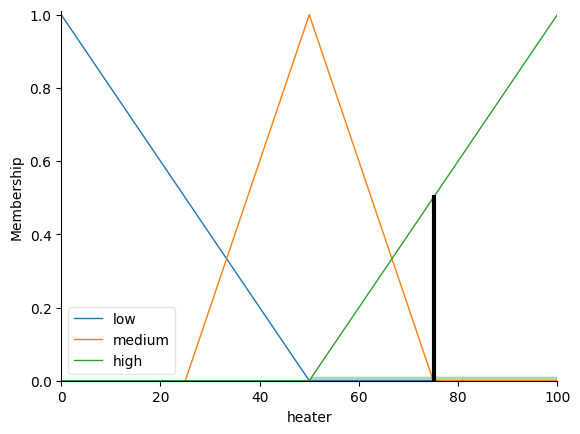

In [29]:
# Visualize the results for heater
heater.view(sim=simulation)

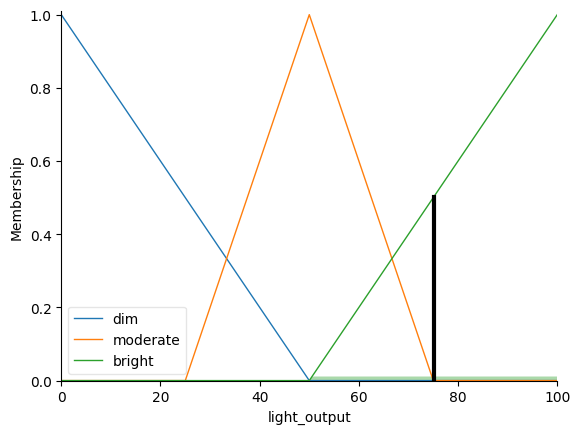

In [30]:
# Visualize the results for light
light_output.view(sim=simulation)

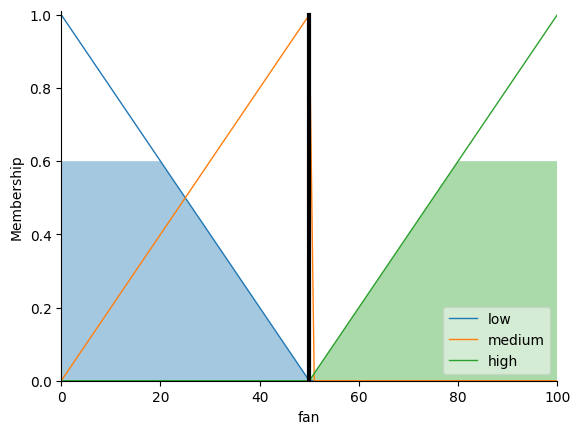

In [31]:
# Visualize the results for fan
fan.view(sim=simulation)

In [32]:
# Manually create a control surface plot for heater output based on temperature and light inputs
temperature_values, light_values = np.meshgrid(temperature_range, light_range)
heater_values = np.zeros_like(temperature_values, dtype=float)  # Change to float

for i in range(len(temperature_range)):
    for j in range(len(light_range)):
        simulation.input['temperature'] = temperature_range[i]
        simulation.input['light'] = light_range[j]

        # Add a default humidity value to avoid missing antecedent input
        simulation.input['humidity'] = 50  # You can try changing this value too

        try:
            # Run the simulation
            simulation.compute()

            # Output the results for debugging
            heater_output = simulation.output['heater'] if 'heater' in simulation.output else None
            print(f"Temperature: {temperature_range[i]}, Light: {light_range[j]}, Heater Output: {heater_output}")

            # Assign heater output to the array
            heater_values[j, i] = heater_output if heater_output is not None else np.nan
        except Exception as e:
            print(f"Error at temperature: {temperature_range[i]}, light: {light_range[j]}: {e}")
            heater_values[j, i] = np.nan  # Handle exceptions with NaN

# Check the heater_values array after the loop
print("Heater Values Array:")
print(heater_values)

Temperature: 0, Light: 0, Heater Output: 76.6507640248123
Temperature: 0, Light: 1, Heater Output: 76.6507640248123
Temperature: 0, Light: 2, Heater Output: 76.6507640248123
Temperature: 0, Light: 3, Heater Output: 76.6507640248123
Temperature: 0, Light: 4, Heater Output: 76.6507640248123
Temperature: 0, Light: 5, Heater Output: 76.6507640248123
Temperature: 0, Light: 6, Heater Output: 76.6507640248123
Temperature: 0, Light: 7, Heater Output: 76.6507640248123
Temperature: 0, Light: 8, Heater Output: 76.6507640248123
Temperature: 0, Light: 9, Heater Output: 76.6507640248123
Temperature: 0, Light: 10, Heater Output: 76.6507640248123
Temperature: 0, Light: 11, Heater Output: 76.6507640248123
Temperature: 0, Light: 12, Heater Output: 76.6507640248123
Temperature: 0, Light: 13, Heater Output: 76.6507640248123
Temperature: 0, Light: 14, Heater Output: 76.6507640248123
Temperature: 0, Light: 15, Heater Output: 76.6507640248123
Temperature: 0, Light: 16, Heater Output: 76.6507640248123
Tempera

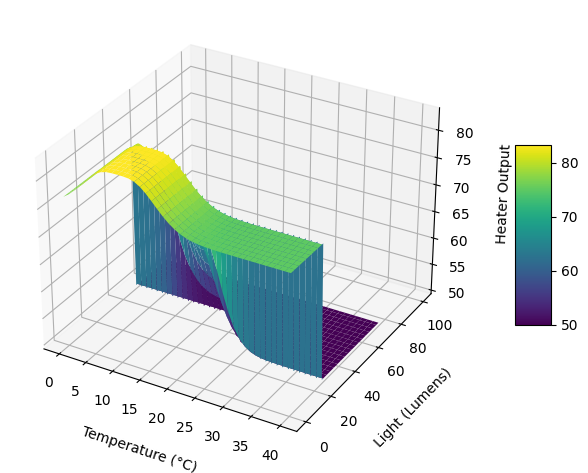

In [33]:
# Create the 3D surface plot with labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with a colormap
surf = ax.plot_surface(temperature_values, light_values, heater_values, cmap='viridis')

# Add axis labels
ax.set_xlabel('Temperature (°C)', labelpad=10)
ax.set_ylabel('Light (Lumens)', labelpad=10)
ax.set_zlabel('Heater Output', labelpad=10)

# Add a color bar to show the scale and position it away from the plot
cbar = fig.colorbar(surf, ax=ax, pad=0.09, shrink=0.4, aspect=5)

# Use tight_layout to prevent overlapping elements
plt.tight_layout()

# Show the plot
plt.show()


# Part 2- FLC Optimization

In [34]:
# Define the Fuzzy Logic Controller class
class FuzzyLogicController:
    def __init__(self):
        self.input = {'temperature': 0, 'light': 0, 'humidity': 0}
        self.output = {'heater': 0, 'light_output': 0, 'fan': 0}
        # Placeholder for fuzzy sets and universe of discourse
        self.temp_cold = None
        self.temp_warm = None
        self.temp_hot = None

        self.light_dim = None
        self.light_moderate = None
        self.light_bright = None

        self.humidity_low = None
        self.humidity_medium = None
        self.humidity_high = None

        self.heater_low = None
        self.heater_medium = None
        self.heater_high = None

        self.light_output_dim = None
        self.light_output_moderate = None
        self.light_output_bright = None

        self.fan_low = None
        self.fan_high = None

        self.x_range = np.arange(0, 181, 1)  # Extended to 180 to accommodate fan up to 170

    def compute(self):
        # Get the input values
        temp = self.input['temperature']
        light = self.input['light']
        humidity = self.input['humidity']

        # Use fuzzy membership functions defined by the chromosome
        temp_level_cold = fuzz.interp_membership(self.x_range, self.temp_cold, temp)
        temp_level_warm = fuzz.interp_membership(self.x_range, self.temp_warm, temp)
        temp_level_hot = fuzz.interp_membership(self.x_range, self.temp_hot, temp)

        light_level_dim = fuzz.interp_membership(self.x_range, self.light_dim, light)
        light_level_moderate = fuzz.interp_membership(self.x_range, self.light_moderate, light)
        light_level_bright = fuzz.interp_membership(self.x_range, self.light_bright, light)

        humidity_level_low = fuzz.interp_membership(self.x_range, self.humidity_low, humidity)
        humidity_level_medium = fuzz.interp_membership(self.x_range, self.humidity_medium, humidity)
        humidity_level_high = fuzz.interp_membership(self.x_range, self.humidity_high, humidity)

        # Example of fuzzy rules:
        # Rule 1: If temperature is cold and light is dim, then heater is high and light_output is bright and fan is low
        heater_activation_high = min(temp_level_cold, light_level_dim)
        light_output_activation_bright = min(temp_level_cold, light_level_dim)
        fan_activation_low = min(temp_level_cold, light_level_dim)

        # Rule 2: If temperature is hot and humidity is high, then fan is high
        fan_activation_high = min(temp_level_hot, humidity_level_high)


        # Aggregate all activations
        heater_activation = heater_activation_high  # Currently only one rule affects heater
        light_output_activation = light_output_activation_bright  # Currently only one rule affects light_output
        fan_activation = max(fan_activation_low, fan_activation_high)  # Combining multiple fan activations

        # Apply the activations to the corresponding fuzzy sets
        # For Heater: High and Low (assuming low is default)
        heater_mfx = heater_activation * self.heater_high + (1 - heater_activation) * self.heater_low

        # For Light Output: Bright and Dim (assuming dim is default)
        light_output_mfx = light_output_activation * self.light_output_bright + (1 - light_output_activation) * self.light_output_dim

        # For Fan: High and Low
        fan_mfx = fan_activation * self.fan_high + (1 - fan_activation) * self.fan_low

        # Defuzzify to get crisp output
        self.output['heater'] = fuzz.defuzz(self.x_range, heater_mfx, 'centroid')
        self.output['light_output'] = fuzz.defuzz(self.x_range, light_output_mfx, 'centroid')
        self.output['fan'] = fuzz.defuzz(self.x_range, fan_mfx, 'centroid')


In [35]:
# Population initialization
def initialize_population(pop_size, chromosome_length):
    population = []
    for _ in range(pop_size):
        chromosome = [random.uniform(0, 180) for _ in range(chromosome_length)]

        # Ensure that the temperature, light, humidity, heater, light_output, and fan sets are sorted
        # Temperature: 3 sets (cold, warm, hot) with 2 parameters each (mean, sigma) for gaussmf
        chromosome[0:6] = sorted(chromosome[0:6])

        # Light: 3 sets (dim, moderate, bright) with 4 parameters each for trapmf
        light_dim = sorted(chromosome[6:10])
        light_moderate = sorted(chromosome[10:14])
        light_bright = sorted(chromosome[14:18])
        chromosome[6:18] = light_dim + light_moderate + light_bright

        # Humidity: 3 sets (low, medium, high) with 4 parameters each for trapmf
        humidity_low = sorted(chromosome[18:22])
        humidity_medium = sorted(chromosome[22:26])
        humidity_high = sorted(chromosome[26:30])
        chromosome[18:30] = humidity_low + humidity_medium + humidity_high

        # Heater: 3 sets (low, medium, high) with 3 parameters each for trimf
        heater_low = sorted(chromosome[30:33])
        heater_medium = sorted(chromosome[33:36])
        heater_high = sorted(chromosome[36:39])
        chromosome[30:39] = heater_low + heater_medium + heater_high

        # Light Output: 3 sets (dim, moderate, bright) with 3 parameters each for trimf
        light_output_dim = sorted(chromosome[39:42])
        light_output_moderate = sorted(chromosome[42:45])
        light_output_bright = sorted(chromosome[45:48])
        chromosome[39:48] = light_output_dim + light_output_moderate + light_output_bright

        # Fan: 2 sets (low, high) with 3 parameters each for trimf
        fan_low = sorted(chromosome[48:51])
        fan_high = sorted(chromosome[51:54])
        chromosome[48:54] = fan_low + fan_high

        population.append(chromosome)
    return population

In [36]:
chromosome_length = 54  # Updated to 54 to accommodate all fuzzy sets

def apply_chromosome_to_flc(chromosome, flc):
    print("Chromosome values:", chromosome)

    # Define the universe of discourse for the fuzzy sets (e.g., from 0 to 180 for fan)
    x_range = flc.x_range  # np.arange(0, 181, 1)

    # Apply to temperature fuzzy sets (gaussmf with mean and sigma)
    temp_mean_cold, temp_sigma_cold, temp_mean_warm, temp_sigma_warm, temp_mean_hot, temp_sigma_hot = chromosome[0:6]
    flc.temp_cold = fuzz.gaussmf(x_range, temp_mean_cold, temp_sigma_cold)
    flc.temp_warm = fuzz.gaussmf(x_range, temp_mean_warm, temp_sigma_warm)
    flc.temp_hot = fuzz.gaussmf(x_range, temp_mean_hot, temp_sigma_hot)

    # Apply to light fuzzy sets (trapmf)
    light_dim = chromosome[6:10]
    light_moderate = chromosome[10:14]
    light_bright = chromosome[14:18]
    flc.light_dim = fuzz.trapmf(x_range, light_dim)
    flc.light_moderate = fuzz.trapmf(x_range, light_moderate)
    flc.light_bright = fuzz.trapmf(x_range, light_bright)

    # Apply to humidity fuzzy sets (trapmf)
    humidity_low = chromosome[18:22]
    humidity_medium = chromosome[22:26]
    humidity_high = chromosome[26:30]
    flc.humidity_low = fuzz.trapmf(x_range, humidity_low)
    flc.humidity_medium = fuzz.trapmf(x_range, humidity_medium)
    flc.humidity_high = fuzz.trapmf(x_range, humidity_high)

    # Apply to heater fuzzy sets (trimf)
    heater_low = chromosome[30:33]
    heater_medium = chromosome[33:36]
    heater_high = chromosome[36:39]
    flc.heater_low = fuzz.trimf(x_range, heater_low)
    flc.heater_medium = fuzz.trimf(x_range, heater_medium)
    flc.heater_high = fuzz.trimf(x_range, heater_high)

    # Apply to light_output fuzzy sets (trimf)
    light_output_dim = chromosome[39:42]
    light_output_moderate = chromosome[42:45]
    light_output_bright = chromosome[45:48]
    flc.light_output_dim = fuzz.trimf(x_range, light_output_dim)
    flc.light_output_moderate = fuzz.trimf(x_range, light_output_moderate)
    flc.light_output_bright = fuzz.trimf(x_range, light_output_bright)

    # Apply to fan fuzzy sets (trimf)
    fan_low = chromosome[48:51]
    fan_high = chromosome[51:54]
    flc.fan_low = fuzz.trimf(x_range, fan_low)
    flc.fan_high = fuzz.trimf(x_range, fan_high)

    return flc

In [37]:
# Fitness function evaluation
def fitness_function(chromosome, dataset, flc):
    try:
        apply_chromosome_to_flc(chromosome, flc)  # Apply chromosome to FLC
    except ValueError as e:
        print("Chromosome application error:", e)
        return float('inf')  # Assign a high error if chromosome is invalid

    total_error = 0
    for idx, sample in enumerate(dataset):
        temperature, light, humidity = sample['inputs']
        expected_outputs = sample['outputs']

        # Run the FLC
        flc.input['temperature'] = temperature
        flc.input['light'] = light
        flc.input['humidity'] = humidity
        flc.compute()

        # Debugging: Print computed outputs
        print(f"Sample {idx}:")
        print(f"Inputs -> Temperature: {temperature}, Light: {light}, Humidity: {humidity}")
        print(f"FLC Outputs -> Heater: {flc.output['heater']:.2f}, Light Output: {flc.output['light_output']:.2f}, Fan: {flc.output['fan']:.2f}")
        print(f"Expected -> Heater: {expected_outputs['heater']}, Light Output: {expected_outputs['light_output']}, Fan: {expected_outputs['fan']}\n")

        # Compute error (squared error)
        heater_error = (flc.output.get('heater', 0) - expected_outputs['heater']) ** 2
        light_error = (flc.output.get('light_output', 0) - expected_outputs['light_output']) ** 2
        fan_error = (flc.output.get('fan', 0) - expected_outputs['fan']) ** 2

        print(f"Errors -> Heater: {heater_error:.2f}, Light Output: {light_error:.2f}, Fan: {fan_error:.2f}\n")

        total_error += heater_error + light_error + fan_error

    average_error = total_error / len(dataset)
    print(f"Total Error for chromosome: {total_error:.2f}, Average Error: {average_error:.2f}\n")
    return average_error


In [38]:
# Crossover
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]

    # Ensure valid fuzzy set values by sorting the respective segments
    # Temperature: first 6 genes (3 gaussmf: mean and sigma)
    child1[0:6] = sorted(child1[0:6])
    child2[0:6] = sorted(child2[0:6])

    # Light: next 12 genes (3 trapmf: a, b, c, d)
    light_dim = sorted(child1[6:10])
    light_moderate = sorted(child1[10:14])
    light_bright = sorted(child1[14:18])
    child1[6:18] = light_dim + light_moderate + light_bright

    light_dim = sorted(child2[6:10])
    light_moderate = sorted(child2[10:14])
    light_bright = sorted(child2[14:18])
    child2[6:18] = light_dim + light_moderate + light_bright

    # Humidity: next 12 genes (3 trapmf: a, b, c, d)
    humidity_low = sorted(child1[18:22])
    humidity_medium = sorted(child1[22:26])
    humidity_high = sorted(child1[26:30])
    child1[18:30] = humidity_low + humidity_medium + humidity_high

    humidity_low = sorted(child2[18:22])
    humidity_medium = sorted(child2[22:26])
    humidity_high = sorted(child2[26:30])
    child2[18:30] = humidity_low + humidity_medium + humidity_high

    # Heater: next 9 genes (3 trimf: a, b, c)
    heater_low = sorted(child1[30:33])
    heater_medium = sorted(child1[33:36])
    heater_high = sorted(child1[36:39])
    child1[30:39] = heater_low + heater_medium + heater_high

    heater_low = sorted(child2[30:33])
    heater_medium = sorted(child2[33:36])
    heater_high = sorted(child2[36:39])
    child2[30:39] = heater_low + heater_medium + heater_high

    # Light Output: next 9 genes (3 trimf: a, b, c)
    light_output_dim = sorted(child1[39:42])
    light_output_moderate = sorted(child1[42:45])
    light_output_bright = sorted(child1[45:48])
    child1[39:48] = light_output_dim + light_output_moderate + light_output_bright

    light_output_dim = sorted(child2[39:42])
    light_output_moderate = sorted(child2[42:45])
    light_output_bright = sorted(child2[45:48])
    child2[39:48] = light_output_dim + light_output_moderate + light_output_bright

    # Fan: last 6 genes (2 trimf: a, b, c)
    fan_low = sorted(child1[48:51])
    fan_high = sorted(child1[51:54])
    child1[48:54] = fan_low + fan_high

    fan_low = sorted(child2[48:51])
    fan_high = sorted(child2[51:54])
    child2[48:54] = fan_low + fan_high

    return child1, child2

In [39]:
# Mutation
def mutate(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            # Mutate based on the type of fuzzy set
            if i < 6:
                # Temperature gaussmf: mean and sigma
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 6 <= i < 18:
                # Light trapmf: a, b, c, d
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 18 <= i < 30:
                # Humidity trapmf: a, b, c, d
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 30 <= i < 39:
                # Heater trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 39 <= i < 48:
                # Light Output trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 48 <= i < 54:
                # Fan trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))

    # Ensure the values for fuzzy sets are sorted after mutation
    # Temperature: first 6 genes (3 gaussmf: mean and sigma)
    chromosome[0:6] = sorted(chromosome[0:6])

    # Light: next 12 genes (3 trapmf: a, b, c, d)
    light_dim = sorted(chromosome[6:10])
    light_moderate = sorted(chromosome[10:14])
    light_bright = sorted(chromosome[14:18])
    chromosome[6:18] = light_dim + light_moderate + light_bright

    # Humidity: next 12 genes (3 trapmf: a, b, c, d)
    humidity_low = sorted(chromosome[18:22])
    humidity_medium = sorted(chromosome[22:26])
    humidity_high = sorted(chromosome[26:30])
    chromosome[18:30] = humidity_low + humidity_medium + humidity_high

    # Heater: next 9 genes (3 trimf: a, b, c)
    heater_low = sorted(chromosome[30:33])
    heater_medium = sorted(chromosome[33:36])
    heater_high = sorted(chromosome[36:39])
    chromosome[30:39] = heater_low + heater_medium + heater_high

    # Light Output: next 9 genes (3 trimf: a, b, c)
    light_output_dim = sorted(chromosome[39:42])
    light_output_moderate = sorted(chromosome[42:45])
    light_output_bright = sorted(chromosome[45:48])
    chromosome[39:48] = light_output_dim + light_output_moderate + light_output_bright

    # Fan: last 6 genes (2 trimf: a, b, c)
    fan_low = sorted(chromosome[48:51])
    fan_high = sorted(chromosome[51:54])
    chromosome[48:54] = fan_low + fan_high

    return chromosome

In [40]:
# Select parents using tournament selection
def select_parents(population, fitness_scores):
    tournament_size = 5
    selected_indices = random.sample(range(len(population)), min(tournament_size, len(population)))
    selected_fitness = [fitness_scores[i] for i in selected_indices]
    parent1 = population[selected_indices[selected_fitness.index(min(selected_fitness))]]

    selected_indices = random.sample(range(len(population)), min(tournament_size, len(population)))
    selected_fitness = [fitness_scores[i] for i in selected_indices]
    parent2 = population[selected_indices[selected_fitness.index(min(selected_fitness))]]

    return parent1, parent2

In [41]:
# Genetic Algorithm
def genetic_algorithm(pop_size, generations, mutation_rate, dataset, chromosome_length):
    population = initialize_population(pop_size, chromosome_length)

    # Initialize the FLC
    flc = FuzzyLogicController()

    for generation in range(generations):
        print(f"Generation {generation+1}/{generations}")
        # Evaluate fitness
        fitness_scores = [fitness_function(chromosome, dataset, flc) for chromosome in population]

        # Find and print the best fitness in the current generation
        best_fitness = min(fitness_scores)
        best_index = fitness_scores.index(best_fitness)
        print(f"Best fitness in generation {generation+1}: {best_fitness}\n")

        # Select parents and generate next generation
        next_population = []
        while len(next_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutate(child1, mutation_rate))
            if len(next_population) < pop_size:
                next_population.append(mutate(child2, mutation_rate))

        population = next_population

    # Return the best chromosome after evolution
    final_fitness_scores = [fitness_function(chromosome, dataset, flc) for chromosome in population]
    best_chromosome = population[final_fitness_scores.index(min(final_fitness_scores))]
    return best_chromosome


In [42]:
# Dataset of input-output examples (xi, yi)
dataset = [
    {'inputs': (5, 20, 30), 'outputs': {'heater': 70, 'light_output': 80, 'fan': 30}},
    {'inputs': (10, 25, 40), 'outputs': {'heater': 65, 'light_output': 75, 'fan': 40}},
    {'inputs': (15, 30, 50), 'outputs': {'heater': 60, 'light_output': 70, 'fan': 50}},
    {'inputs': (20, 35, 60), 'outputs': {'heater': 55, 'light_output': 65, 'fan': 60}},
    {'inputs': (25, 40, 70), 'outputs': {'heater': 50, 'light_output': 60, 'fan': 70}},
    {'inputs': (30, 45, 80), 'outputs': {'heater': 45, 'light_output': 55, 'fan': 80}},
    {'inputs': (35, 50, 90), 'outputs': {'heater': 40, 'light_output': 50, 'fan': 90}},
    {'inputs': (40, 55, 100), 'outputs': {'heater': 35, 'light_output': 45, 'fan': 100}},
    {'inputs': (45, 60, 110), 'outputs': {'heater': 30, 'light_output': 40, 'fan': 110}},
    {'inputs': (50, 65, 120), 'outputs': {'heater': 25, 'light_output': 35, 'fan': 120}},
    {'inputs': (55, 70, 130), 'outputs': {'heater': 20, 'light_output': 30, 'fan': 130}},
    {'inputs': (60, 75, 140), 'outputs': {'heater': 15, 'light_output': 25, 'fan': 140}},
    {'inputs': (65, 80, 150), 'outputs': {'heater': 10, 'light_output': 20, 'fan': 150}},
    {'inputs': (70, 85, 160), 'outputs': {'heater': 5, 'light_output': 15, 'fan': 160}},
    {'inputs': (75, 90, 170), 'outputs': {'heater': 0, 'light_output': 10, 'fan': 170}},
]

In [43]:
# Run the genetic algorithm
best_chromosome = genetic_algorithm(
    pop_size=20,
    generations=50,
    mutation_rate=0.1,
    dataset=dataset,
    chromosome_length=54
)

Streaming output truncated to the last 5000 lines.
FLC Outputs -> Heater: 40.03, Light Output: 50.45, Fan: 105.09
Expected -> Heater: 50, Light Output: 60, Fan: 70

Errors -> Heater: 99.44, Light Output: 91.26, Fan: 1231.06

Sample 5:
Inputs -> Temperature: 30, Light: 45, Humidity: 80
FLC Outputs -> Heater: 40.04, Light Output: 50.45, Fan: 106.10
Expected -> Heater: 45, Light Output: 55, Fan: 80

Errors -> Heater: 24.65, Light Output: 20.75, Fan: 681.39

Sample 6:
Inputs -> Temperature: 35, Light: 50, Humidity: 90
FLC Outputs -> Heater: 40.03, Light Output: 50.45, Fan: 107.12
Expected -> Heater: 40, Light Output: 50, Fan: 90

Errors -> Heater: 0.00, Light Output: 0.20, Fan: 293.00

Sample 7:
Inputs -> Temperature: 40, Light: 55, Humidity: 100
FLC Outputs -> Heater: 40.03, Light Output: 50.45, Fan: 107.18
Expected -> Heater: 35, Light Output: 45, Fan: 100

Errors -> Heater: 25.28, Light Output: 29.67, Fan: 51.60

Sample 8:
Inputs -> Temperature: 45, Light: 60, Humidity: 110
FLC Outputs 

/usr/local/lib/python3.10/dist-packages/skfuzzy/membership/generatemf.py:83: RuntimeWarning: divide by zero encountered in divide
  return np.exp(-((x - mean)**2.) / (2 * sigma**2.))
/usr/local/lib/python3.10/dist-packages/skfuzzy/membership/generatemf.py:83: RuntimeWarning: invalid value encountered in divide
  return np.exp(-((x - mean)**2.) / (2 * sigma**2.))


Streaming output truncated to the last 5000 lines.
Expected -> Heater: 15, Light Output: 25, Fan: 140

Errors -> Heater: 523.47, Light Output: 474.17, Fan: 1279.02

Sample 12:
Inputs -> Temperature: 65, Light: 80, Humidity: 150
FLC Outputs -> Heater: 37.88, Light Output: 46.78, Fan: 101.52
Expected -> Heater: 10, Light Output: 20, Fan: 150

Errors -> Heater: 777.27, Light Output: 716.93, Fan: 2350.03

Sample 13:
Inputs -> Temperature: 70, Light: 85, Humidity: 160
FLC Outputs -> Heater: 37.88, Light Output: 46.78, Fan: 98.79
Expected -> Heater: 5, Light Output: 15, Fan: 160

Errors -> Heater: 1081.07, Light Output: 1009.68, Fan: 3746.24

Sample 14:
Inputs -> Temperature: 75, Light: 90, Humidity: 170
FLC Outputs -> Heater: 37.88, Light Output: 46.78, Fan: 96.05
Expected -> Heater: 0, Light Output: 10, Fan: 170

Errors -> Heater: 1434.86, Light Output: 1352.44, Fan: 5468.90

Total Error for chromosome: 39418.20, Average Error: 2627.88

Chromosome values: [7.618615272796855, 9.921477574569

In [44]:
# Print the best chromosome
print("Best chromosome:", best_chromosome)

Best chromosome: [9.921477574569513, 10.112664659254204, 134.06644217705534, 148.01119778995832, 149.16067296750052, 171.32908960466185, 35.01110891566279, 70.0696335205124, 130.6991901626, 148.3179575965013, 0, 9.696474730631042, 91.95004725514748, 129.9036568538822, 63.339194394121385, 78.69131506739664, 97.98452366652671, 123.20240821566377, 27.016508724266515, 88.69543015572322, 127.23802227812105, 138.63937233023415, 23.638525776951273, 70.74591051478458, 87.53132753369154, 124.65656520377439, 63.10274183741594, 97.77827038156614, 97.9443552911782, 180, 0, 0, 112.88502355855067, 16.267163572783186, 24.75698055346625, 100.89713288927423, 15.574400023469378, 67.82147810686244, 92.96534325508703, 0.32093444372783253, 45.34739327095302, 94.35301452626466, 18.492909393004474, 86.75053619172839, 173.59843073241083, 26.083492600268507, 50.41194312958622, 55.99424584809388, 44.49502350859637, 100.28634985775932, 125.67609439204483, 68.90977977517029, 120.3325721074547, 154.13642342962896]

Chromosome values: [9.921477574569513, 10.112664659254204, 134.06644217705534, 148.01119778995832, 149.16067296750052, 171.32908960466185, 35.01110891566279, 70.0696335205124, 130.6991901626, 148.3179575965013, 0, 9.696474730631042, 91.95004725514748, 129.9036568538822, 63.339194394121385, 78.69131506739664, 97.98452366652671, 123.20240821566377, 27.016508724266515, 88.69543015572322, 127.23802227812105, 138.63937233023415, 23.638525776951273, 70.74591051478458, 87.53132753369154, 124.65656520377439, 63.10274183741594, 97.77827038156614, 97.9443552911782, 180, 0, 0, 112.88502355855067, 16.267163572783186, 24.75698055346625, 100.89713288927423, 15.574400023469378, 67.82147810686244, 92.96534325508703, 0.32093444372783253, 45.34739327095302, 94.35301452626466, 18.492909393004474, 86.75053619172839, 173.59843073241083, 26.083492600268507, 50.41194312958622, 55.99424584809388, 44.49502350859637, 100.28634985775932, 125.67609439204483, 68.90977977517029, 120.3325721074547, 154.1364234296289

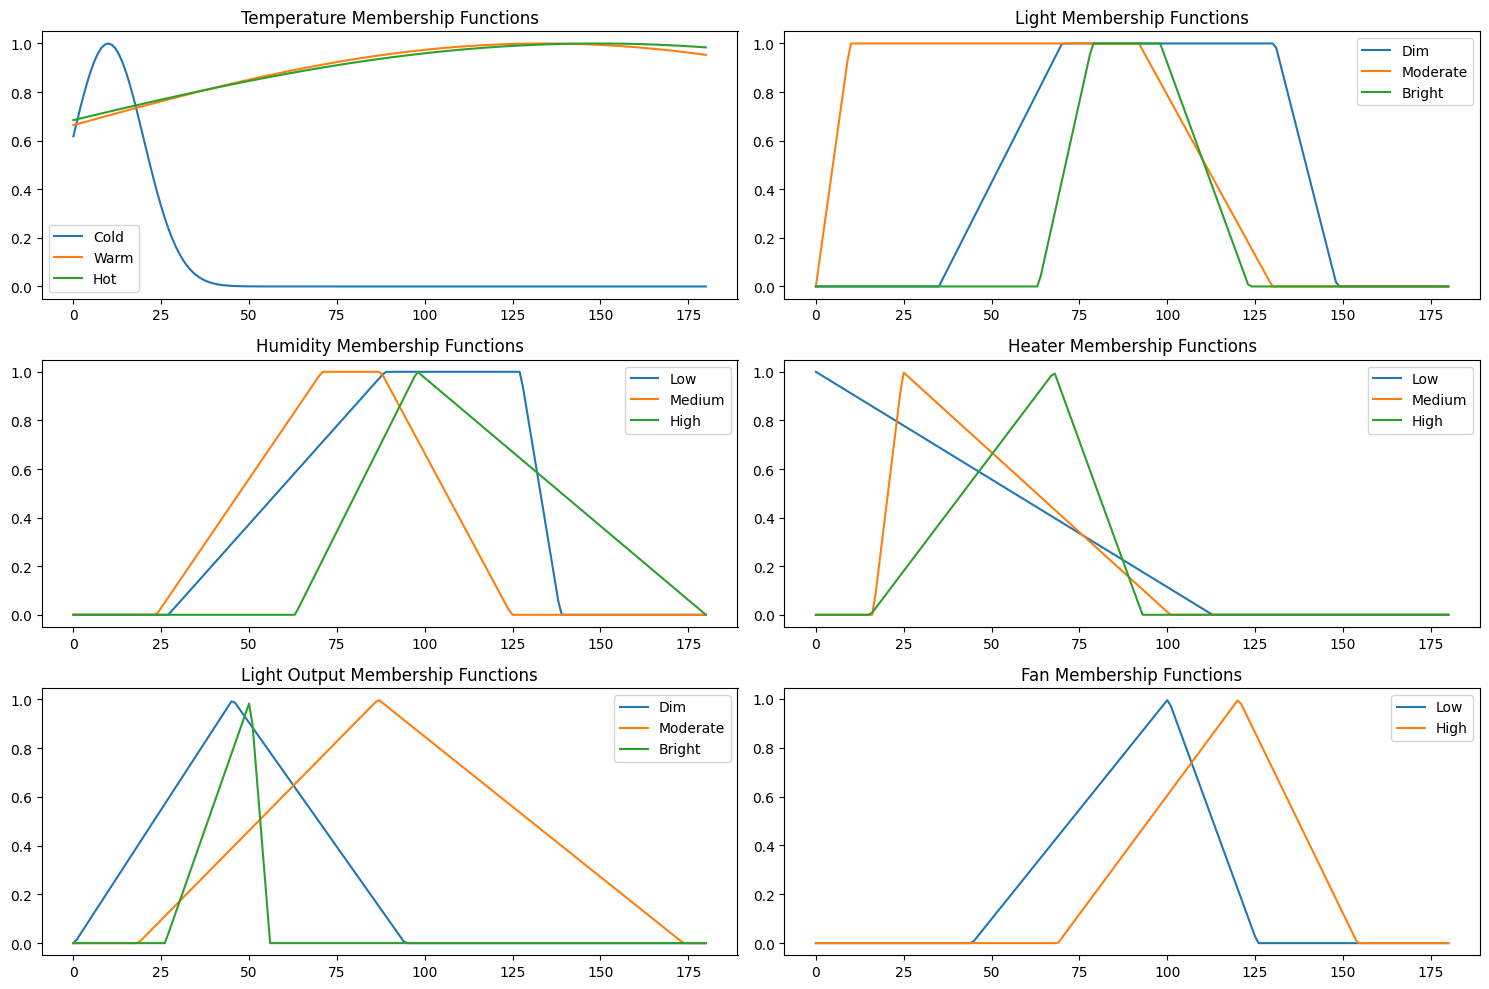

In [45]:
def visualize_membership_functions(flc):
    plt.figure(figsize=(15, 10))

    # Temperature
    plt.subplot(3, 2, 1)
    plt.plot(flc.x_range, flc.temp_cold, label='Cold')
    plt.plot(flc.x_range, flc.temp_warm, label='Warm')
    plt.plot(flc.x_range, flc.temp_hot, label='Hot')
    plt.title('Temperature Membership Functions')
    plt.legend()

    # Light
    plt.subplot(3, 2, 2)
    plt.plot(flc.x_range, flc.light_dim, label='Dim')
    plt.plot(flc.x_range, flc.light_moderate, label='Moderate')
    plt.plot(flc.x_range, flc.light_bright, label='Bright')
    plt.title('Light Membership Functions')
    plt.legend()

    # Humidity
    plt.subplot(3, 2, 3)
    plt.plot(flc.x_range, flc.humidity_low, label='Low')
    plt.plot(flc.x_range, flc.humidity_medium, label='Medium')
    plt.plot(flc.x_range, flc.humidity_high, label='High')
    plt.title('Humidity Membership Functions')
    plt.legend()

    # Heater
    plt.subplot(3, 2, 4)
    plt.plot(flc.x_range, flc.heater_low, label='Low')
    plt.plot(flc.x_range, flc.heater_medium, label='Medium')
    plt.plot(flc.x_range, flc.heater_high, label='High')
    plt.title('Heater Membership Functions')
    plt.legend()

    # Light Output
    plt.subplot(3, 2, 5)
    plt.plot(flc.x_range, flc.light_output_dim, label='Dim')
    plt.plot(flc.x_range, flc.light_output_moderate, label='Moderate')
    plt.plot(flc.x_range, flc.light_output_bright, label='Bright')
    plt.title('Light Output Membership Functions')
    plt.legend()

    # Fan
    plt.subplot(3, 2, 6)
    plt.plot(flc.x_range, flc.fan_low, label='Low')
    plt.plot(flc.x_range, flc.fan_high, label='High')
    plt.title('Fan Membership Functions')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage after applying the best chromosome
flc = FuzzyLogicController()
apply_chromosome_to_flc(best_chromosome, flc)
visualize_membership_functions(flc)


# Part 3

In [46]:
# CEC'2005 Function F1 (Sphere Function)
def F1(x):
    return sum(x**2)

In [47]:
# CEC'2005 Function F9 (Rastrigin Function)
def F9(x):
    return sum(x**2 - 10 * np.cos(2 * np.pi * x) + 10)

In [48]:
# Define bounds for the CEC'2005 problem
def get_bounds(dimension):
    lower_bound = -100
    upper_bound = 100
    bounds = [(lower_bound, upper_bound) for _ in range(dimension)]
    return bounds

In [49]:
# PSO Optimization function (no c1, c2 parameters)
def pso_optimization(func, dimension, max_iter, swarmsize=50):
    lb, ub = [-100]*dimension, [100]*dimension
    best_pos, best_val = pso(func, lb, ub, swarmsize=swarmsize, maxiter=max_iter, minfunc=1e-6, minstep=1e-8)
    return best_pos, best_val

In [50]:
# DE Optimization function
def de_optimization(func, dimension, max_iter, popsize=20):
    bounds = get_bounds(dimension)
    result = differential_evolution(func, bounds, maxiter=max_iter, popsize=popsize, disp=True)
    return result.x, result.fun

In [51]:
# Performing multiple trials for each optimizer
def perform_trials(func, optimizer, dimension, max_iter, trials=3, **kwargs):
    results = []
    for i in range(trials):
        best_pos, best_val = optimizer(func, dimension, max_iter, **kwargs)
        print(f"Trial {i+1}/{trials} completed: Best Value = {best_val}")
        results.append(best_val)
    return np.mean(results), np.std(results)

In [52]:
# Settings
dimension = 30
max_iter = 100
trials = 3
swarmsize = 50
popsize = 20

In [53]:
# Perform PSO and DE on F1
print("Optimizing F1 using PSO and DE:")
mean_val_pso_F1, std_val_pso_F1 = perform_trials(F1, pso_optimization, dimension, max_iter, trials, swarmsize=swarmsize)
mean_val_de_F1, std_val_de_F1 = perform_trials(F1, de_optimization, dimension, max_iter, trials, popsize=popsize)

Optimizing F1 using PSO and DE:
Stopping search: maximum iterations reached --> 100
Trial 1/3 completed: Best Value = 6278.943258536864
Stopping search: maximum iterations reached --> 100
Trial 2/3 completed: Best Value = 9877.297902586655
Stopping search: maximum iterations reached --> 100
Trial 3/3 completed: Best Value = 6456.593034463144
differential_evolution step 1: f(x)= 43511.655671871165
differential_evolution step 2: f(x)= 43511.655671871165
differential_evolution step 3: f(x)= 39499.620709614406
differential_evolution step 4: f(x)= 39499.620709614406
differential_evolution step 5: f(x)= 33633.4456605446
differential_evolution step 6: f(x)= 32421.774048311145
differential_evolution step 7: f(x)= 30126.448254281244
differential_evolution step 8: f(x)= 22229.182701462305
differential_evolution step 9: f(x)= 19491.095849605266
differential_evolution step 10: f(x)= 17562.082275079378
differential_evolution step 11: f(x)= 17562.082275079378
differential_evolution step 12: f(x)= 17

In [54]:
# Perform PSO and DE on F9
print("Optimizing F9 using PSO and DE:")
mean_val_pso_F9, std_val_pso_F9 = perform_trials(F9, pso_optimization, dimension, max_iter, trials, swarmsize=swarmsize)
mean_val_de_F9, std_val_de_F9 = perform_trials(F9, de_optimization, dimension, max_iter, trials, popsize=popsize)

Optimizing F9 using PSO and DE:
Stopping search: maximum iterations reached --> 100
Trial 1/3 completed: Best Value = 4748.055577755852
Stopping search: Swarm best objective change less than 1e-06
Trial 2/3 completed: Best Value = 8651.352580001056
Stopping search: maximum iterations reached --> 100
Trial 3/3 completed: Best Value = 11331.163348913205
differential_evolution step 1: f(x)= 43933.512554069704
differential_evolution step 2: f(x)= 31144.78509826589
differential_evolution step 3: f(x)= 31144.78509826589
differential_evolution step 4: f(x)= 31144.78509826589
differential_evolution step 5: f(x)= 26518.893376255644
differential_evolution step 6: f(x)= 20669.077475812515
differential_evolution step 7: f(x)= 20669.077475812515
differential_evolution step 8: f(x)= 16487.702061261032
differential_evolution step 9: f(x)= 14708.977119417403
differential_evolution step 10: f(x)= 10961.013623466484
differential_evolution step 11: f(x)= 10961.013623466484
differential_evolution step 12:

In [55]:
# Display results
print(f"PSO on F1: Mean = {mean_val_pso_F1}, Std = {std_val_pso_F1}")
print(f"DE on F1: Mean = {mean_val_de_F1}, Std = {std_val_de_F1}")

print(f"PSO on F9: Mean = {mean_val_pso_F9}, Std = {std_val_pso_F9}")
print(f"DE on F9: Mean = {mean_val_de_F9}, Std = {std_val_de_F9}")


PSO on F1: Mean = 7537.611398528888, Std = 1655.9970941347706
DE on F1: Mean = 6.852441419298838e-14, Std = 9.583286059978823e-14
PSO on F9: Mean = 8243.523835556705, Std = 2702.96999554988
DE on F9: Mean = 99.16390584955525, Std = 8.137266574246135
